In [128]:
"""Gaskell Eros Shape Model V1.0 data set, ID:                           
        NEAR-A-MSI-5-EROSSHAPE-V1.0. """
%matplotlib notebook
import numpy as np, matplotlib.pyplot as plt, pymesh, trimesh
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from points import *
from LS import *
from scipy.spatial.transform import Rotation as R
from numpy import pi as π, sin, cos, tan, sqrt, log, arctanh
from matplotlib import cm

In [111]:
def fix_mesh(mesh, detail="normal"):
    bbox_min, bbox_max = mesh.bbox;
    diag_len = norm(bbox_max - bbox_min);
    if detail == "normal":
        target_len = diag_len * 2e-2;
    elif detail == "high":
        target_len = diag_len * 10e-3;
    elif detail == "low":
        target_len = diag_len * 4e-2;
    print("Target resolution: {} mm".format(target_len));

    count = 0;
    mesh, __ = pymesh.remove_degenerated_triangles(mesh, 100);
    mesh, __ = pymesh.split_long_edges(mesh, target_len);
    num_vertices = mesh.num_vertices;
    while True:
        mesh, __ = pymesh.collapse_short_edges(mesh, 1e-6);
        mesh, __ = pymesh.collapse_short_edges(mesh, target_len,
                preserve_feature=True);
        mesh, __ = pymesh.remove_obtuse_triangles(mesh, 150.0, 100);
        if mesh.num_vertices == num_vertices:
            break;

        num_vertices = mesh.num_vertices;
        print("#v: {}".format(num_vertices));
        count += 1;
        if count > 10: break;

    mesh = pymesh.resolve_self_intersection(mesh);
    mesh, __ = pymesh.remove_duplicated_faces(mesh);
    mesh = pymesh.compute_outer_hull(mesh);
    mesh, __ = pymesh.remove_duplicated_faces(mesh);
    mesh, __ = pymesh.remove_obtuse_triangles(mesh, 179.0, 5);
    mesh, __ = pymesh.remove_isolated_vertices(mesh);

    return mesh

P = np.loadtxt('erosP.dat',usecols=(1,2,3))
T = np.loadtxt('erosT.dat',usecols=(1,2,3)).astype(int)-1
mesh = pymesh.form_mesh(P,T)
mesh = fix_mesh(mesh,detail='low')

P = mesh.nodes
T = mesh.elements
I = trimesh.Trimesh(vertices=P,
                       faces=T,
                       process=False).moment_inertia
Ip, Q = trimesh.inertia.principal_axis(I)
RR = np.array([[0,0,1],[0,1,0],[1,0,0]]).astype(float)
P = matmul(matmul(P,Q.T),RR)
T, N, C = surface_normals(P, T)

Target resolution: 1.5464224260530626 mm
#v: 218


<IPython.core.display.Javascript object>


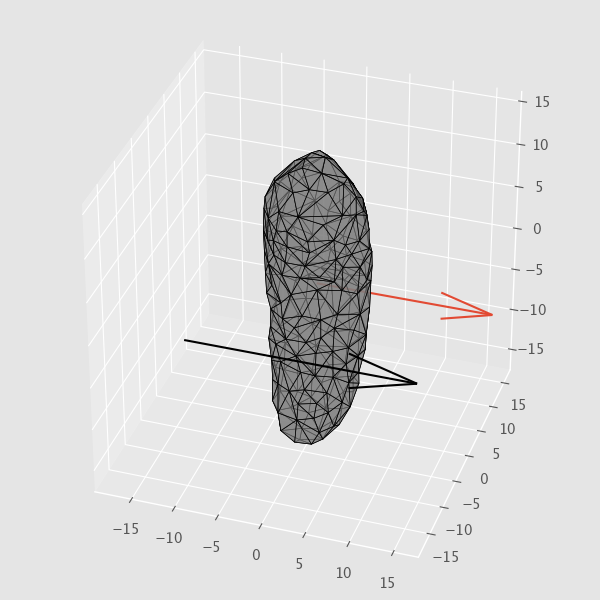

In [112]:
def draw_mesh(mesh):
    fig = plt.figure(figsize=(6, 6),frameon=False)
    ax = mplot3d.Axes3D(fig)

    # Collect face data as vectors for plotting
    F = mesh.elements

    facevectors = np.zeros((F.shape[0],3,3))
    for i, face in enumerate(F):
        for j in range(3):
            facevectors[i][j] = mesh.vertices[face[j],:]
    ax.add_collection3d(mplot3d.art3d.Poly3DCollection(facevectors, facecolor=[0.5,0.5,0.5], lw=0.5,edgecolor=[0,0,0], alpha=0.66))
    
    scale = mesh.vertices.flatten()
    
    I = trimesh.Trimesh(vertices=P,
                       faces=T,
                       process=False).moment_inertia
    Ip, Q = trimesh.inertia.principal_axis(I)
    ax.quiver(0,0,0,Q[2,0],Q[2,1],Q[2,2],length=20,normalize=False)
    ax.quiver(-10,-15,0,1.3,0,0,length=20,normalize=False,color='k')
    ax.auto_scale_xyz(scale, scale, scale)

    plt.show()
    return fig

mesh = pymesh.form_mesh(P,T)
fig = draw_mesh(mesh)

In [123]:
# Use the ZX'Z''- intrinsic rotation notation, where following angles 
# are in corresponding order
λ = np.array([0.])
#β = np.array([π/3])
#λ = np.linspace(0, 2*π, 50)
β = np.linspace(0, π, 50)
φ = np.linspace(0, 2*π, 50)

In [124]:
import time, datetime
Γ = np.zeros([φ.size, β.size, λ.size, 3])

start = time.time()
for i, fi in enumerate(φ):
    if np.mod(i,1)==0: print((i+1),'/',φ.size)
    for j, bj in enumerate(β):
        #print(' ',(j+1),'/',β.size)
        for k, lk in enumerate(λ):
            Γ[i,j,k:] = Γ_LS(P, T, C, N, φ = fi, β = bj, λ = lk, convex = True)
            #print('  ',(k+1),'/',λ.size)
end = time.time()
print('Done in', str(datetime.timedelta(seconds=np.round(end-start,0))))

1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50
Done in 0:00:37


<IPython.core.display.Javascript object>


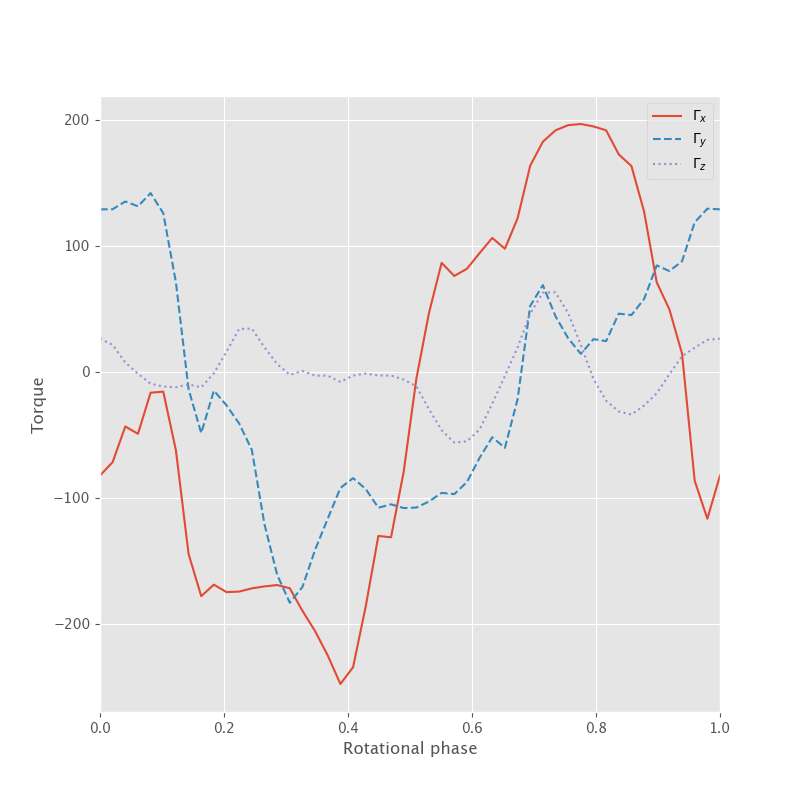

In [125]:
data = Γ.flatten()
np.savetxt('datatest.dat', data)
#data2 = np.loadtxt('data.dat')
#Γ = data2.reshape([φ.size, β.size, λ.size, 3])

fig = plt.figure(figsize=(8,8))
plt.plot(φ/(2*π),Γ[:,0,0,0],label=r'$Γ_x$')
plt.plot(φ/(2*π),Γ[:,0,0,1],'--',label=r'$Γ_y$')
plt.plot(φ/(2*π),Γ[:,0,0,2],':',label=r'$Γ_z$')
plt.xlabel('Rotational phase')
plt.ylabel('Torque')
plt.legend()
plt.xlim([0,1])
plt.show()

<IPython.core.display.Javascript object>


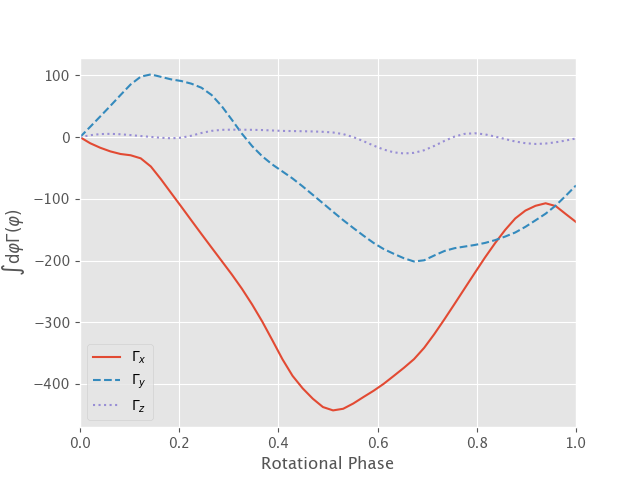

In [126]:
from scipy import integrate

fig = plt.figure()

Γx_int = integrate.cumtrapz(Γ[:,0,0,0], φ, initial=0)
Γy_int = integrate.cumtrapz(Γ[:,0,0,1], φ, initial=0)
Γz_int = integrate.cumtrapz(Γ[:,0,0,2], φ, initial=0)
plt.plot(φ/(2*π), Γx_int, '-',label=r'$Γ_x$')
plt.plot(φ/(2*π), Γy_int, '--',label=r'$Γ_y$')
plt.plot(φ/(2*π), Γz_int, ':',label=r'$Γ_z$')
plt.legend()
plt.xlim([0,1])
plt.xlabel('Rotational Phase')
plt.ylabel(r'$\int\mathrm{d}φ \Gamma(φ)$')

plt.show()

In [130]:
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

data = np.loadtxt('datatest.dat')
#data = np.loadtxt('data_nonconvex.dat')
#data0 = np.loadtxt('data_convex.dat')
Γ = data.reshape([φ.size, β.size, λ.size, 3])
#Γ0 = data0.reshape([φ.size, β.size, λ.size, 3])
#Γ2 = (Γ-Γ0)/Γ

Γ2 = Γ
jjj = 0
for kkk in range(λ.size):
    for iii in range(β.size):
        βi = β[iii]
        λi = λ[kkk]
        Ry = R.from_euler('Y',-βi).as_matrix()
        Ry = Rot.from_euler('ZYZ', [0, -βi, λi]).as_matrix()
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')

        F = mesh.elements

        I = trimesh.Trimesh(vertices=P,
                           faces=T,
                           process=False).moment_inertia
        Ip, Q = trimesh.inertia.principal_axis(I)

        P2 = matmul(mesh.vertices,Ry)
        Q = matmul(Ry, Q)
        facevectors = np.zeros((F.shape[0],3,3))
        for i, face in enumerate(F):
            for j in range(3):
                facevectors[i][j] = P2[face[j],:]

        ax1.add_collection3d(mplot3d.art3d.Poly3DCollection(facevectors, facecolor=[0.5,0.5,0.5], lw=0.5,edgecolor=[0,0,0], alpha=0.66))
        ax1.quiver(0,0,0,Q[2,0],Q[2,1],Q[2,2],length=20,normalize=False,label="body axis")
        ax1.quiver(-10,-18,0,1.3,0,0,length=20,normalize=False,color='k', label="illumination")

        scale = mesh.vertices.flatten()
        ax1.auto_scale_xyz(scale, scale, scale)
        ax1._axis3don = False
        ax1.legend()

        ax2 = fig.add_subplot(1, 2, 2)

        ax2.plot(φ/(2*π),Γ2[:,iii,kkk,0],label=r'$Γ_x$')
        ax2.plot(φ/(2*π),Γ2[:,iii,kkk,1],'--',label=r'$Γ_y$')
        ax2.plot(φ/(2*π),Γ2[:,iii,kkk,2],':',label=r'$Γ_z$')
        ax2.set_xlabel('Rotational phase')
        #ax2.set_ylabel('Torque')
        ax2.legend()
        ax2.set_xlim([0,1])
        #ax2.set_ylim([-3,3])
        plt.suptitle('Torque over rotation about the body axis for different body axis orientations')
        plt.savefig(str(jjj+1)+'.png')
        jjj += 1

    for iii in range(β.size-1):
        βi = β[-1 - iii]
        λi = λ[kkk]
        Ry = R.from_euler('Y',-βi).as_matrix()
        Ry = Rot.from_euler('ZYZ', [0, -βi, λi]).as_matrix()
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')

        F = mesh.elements

        I = trimesh.Trimesh(vertices=P,
                           faces=T,
                           process=False).moment_inertia
        Ip, Q = trimesh.inertia.principal_axis(I)

        P2 = matmul(mesh.vertices,Ry)
        Q = matmul(Ry, Q)
        facevectors = np.zeros((F.shape[0],3,3))
        for i, face in enumerate(F):
            for j in range(3):
                facevectors[i][j] = P2[face[j],:]

        ax1.add_collection3d(mplot3d.art3d.Poly3DCollection(facevectors, facecolor=[0.5,0.5,0.5], lw=0.5,edgecolor=[0,0,0], alpha=0.66))
        ax1.quiver(0,0,0,Q[2,0],Q[2,1],Q[2,2],length=20,normalize=False,label="body axis")
        ax1.quiver(-10,-18,0,1.3,0,0,length=20,normalize=False,color='k', label="illumination")

        scale = mesh.vertices.flatten()
        ax1.auto_scale_xyz(scale, scale, scale)
        ax1._axis3don = False
        ax1.legend()

        ax2 = fig.add_subplot(1, 2, 2)

        ax2.plot(φ/(2*π),Γ2[:,-1 - iii,kkk,0],label=r'$Γ_x$')
        ax2.plot(φ/(2*π),Γ2[:,-1 - iii,kkk,1],'--',label=r'$Γ_y$')
        ax2.plot(φ/(2*π),Γ2[:,-1 - iii,kkk,2],':',label=r'$Γ_z$')
        ax2.set_xlabel('Rotational phase')
        #ax2.set_ylabel('Torque')
        ax2.legend()
        ax2.set_xlim([0,1])
        #ax2.set_ylim([-3,3])
        plt.suptitle('Torque over rotation about the body axis for different body axis orientations')
        plt.savefig(str(jjj+1)+'.png')
        jjj += 1
        clear_output(wait=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [5]:
import imageio
image_list = []
for i in range(1,2701):
    image_list.append(imageio.imread(str(i)+'.png'))
imageio.mimwrite('anim_long.mp4', image_list, fps=30)

<IPython.core.display.Javascript object>


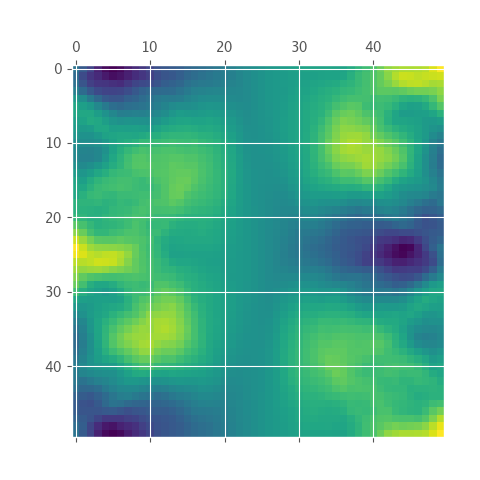

<IPython.core.display.Javascript object>


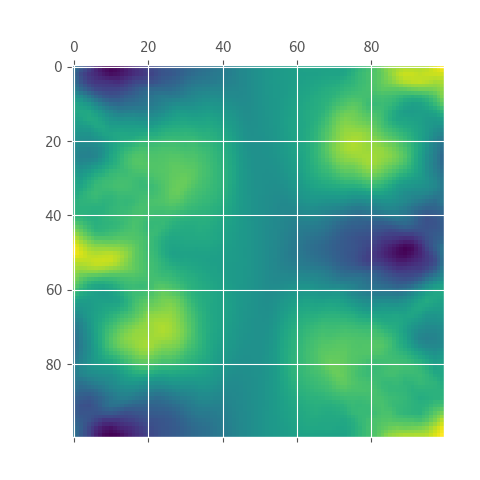

In [121]:
from scipy.interpolate import interpn
data = np.loadtxt('data.dat')
Γ = data.reshape([φ.size, β.size, λ.size, 3])

gx, gy, gz = np.meshgrid(φ,β,λ)
φn = np.linspace(0, 2*π, 100)
βn = np.linspace(0, π, 100)
λn = np.linspace(0, 2*π, 100)
gxn, gyn, gzn = np.meshgrid(φn,βn,λn)
xi = np.vstack(([[gxn.flatten()],[gyn.flatten()],[gzn.flatten()]])).T

values = interpn([φ,β,λ], Γ[:,:,:,0], xi)
values = values.reshape(gxn.shape)
fig = plt.matshow(Γ[:,:,0,0])
plt.show()
fig = plt.matshow(values[:,:,0].T)
plt.show()

In [115]:
# Alignment coordinates
ξ = np.linspace(0, π, 50)
φ = np.linspace(0, 2*π, 50)
ψ = 0

import time, datetime
Γ = np.zeros([ξ.size, 3])

start = time.time()
for i, xi in enumerate(ξ):
    if np.mod(i,1)==0: print((i+1),'/',ξ.size)
    for j, fj in enumerate(φ):
        #print(' ',(j+1),'/',β.size)
        Γ[i] += Γ_LS(P, T, C, N, φ = 0, β = xi, λ = fj)
            #print('  ',(k+1),'/',λ.size)
Γ = Γ/φ.size
end = time.time()
print('Done in', str(datetime.timedelta(seconds=np.round(end-start,0))))

1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50
39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50
Done in 0:00:36


<IPython.core.display.Javascript object>


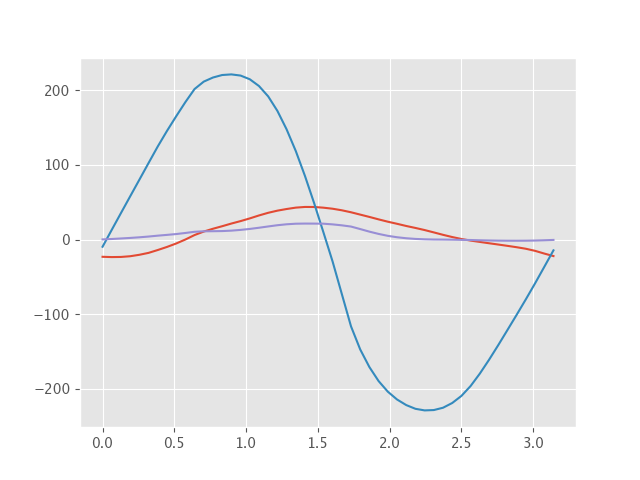

In [118]:
fig = plt.figure()
plt.plot(ξ,Γ[:,0],label=)
plt.show()